In [1]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy import cos, sin, pi
from numpy.random import randint as r_int

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout, GaussianNoise, GaussianDropout


from PIL import Image as IM, ImageDraw as ID, ImageFilter as IF

from IPython.display import display, Image


In [2]:
def init_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (200, 200,1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (8, 8)))
    model.add(GaussianDropout(0.1))
    model.add(Conv2D(16, (8, 8), activation='relu'))
    model.add(GaussianNoise(1))
    model.add(Flatten())
    model.add(Dense(units = 64, activation = 'sigmoid'))
    model.add(Dense(units = 7, activation = 'softmax'))
    model.summary()
    return model

In [3]:
# Generates the Transformation Matrix for a Point
#   coord: The (x,y,z) point to transform
#   angle: The (a,b,c) angle to transform by
def shear_trans(coord=(0,0,0),angle=(0,0,0)):
    rot_x = np.array([[1,0,0],
                      [0,cos(angle[0]), sin(angle[0])],
                      [0,-sin(angle[0]),cos(angle[0])]],
                    dtype='float32')
    rot_y = np.array([[cos(angle[1]), 0, sin(angle[1])],
                      [0, 1, 0],
                      [-sin(angle[1]), 0, cos(angle[1])]],
                    dtype='float32')
    rot_z = np.array([[cos(angle[2]), -sin(angle[2]), 0],
                      [sin(angle[2]), cos(angle[2]), 0],
                      [0, 0, 1]],
                    dtype='float32')

    return np.dot(rot_x, rot_y, rot_z)

# Generates Points for Polygons of Specified Features
#   sides: Number of sides of polygon [default:3]
#   coord: Center of the polygon  
#   angle: Angle to rotate about center
#   scale: Value to magnify the polygon
#   shear: 3d Rotation to apply to polygon
def poly_gen(sides = 3,coord = (0,0), angle = 0, scale = 1, shear = (0,0,0)):
    p,x,y = [], *coord
    
    #Loop Through and Create All Verticies
    for s in range(sides):
        p.append( ( cos(s * 2 * pi / sides + angle) + x, sin(s * 2 * pi / sides + angle) + y))
        
    # Perform Shear Transform
    p = map(lambda q: np.dot(shear_trans((0,0,0), shear), np.array([*q,0]).T), p)
    p = list(map(lambda q: tuple(scale * (1 +  q.T[:-1] + np.array([x,y]))), p))
    
    return p

# Generates Data Set of Polygons
#   size: Number of Polygons to generate/Data Set Size
#   side_range: Range of sides
#   dim: Dimensions of the image
#   color: Color of the polygon
#   filled: Wether or not to fill in the polygon
#   output_dir: Whether or not to save images & where to save them
#   seed: Seed for numpy.random
def gen_poly_data(size = 1,side_range=(3,10), dim = (100,100), color=0, filled=True, output_dir = None, seed = 0):

    np.random.seed(seed)
    data = {'x':[],'y':[],'img':[]}
    few = 20
    # Generate Random Shapes
    for i in range(size):
        img = IM.new('L', dim,"#ffffff")
        draw = ID.Draw(img) 
        center = (1,1)#np.random.rand(2) * 3
        scale = np.random.randint(np.min(dim)/8, np.min(dim)/4)
        fill_color = color if filled else None
        num_sides = r_int(*side_range)

        draw.polygon(poly_gen(sides = num_sides,
                             coord = center,
                             angle = 0 * 2 * pi * np.random.rand(),
                             scale = scale,
                             shear = pi / 2 * np.random.rand(3) - pi/4),
                     fill = fill_color, outline = color)
        
        img = img.filter(IF.BLUR)
        data['img'].append(img)
        if few > 0:
            display(img)
            few = few - 1
        
        # Save Image to output folder if given
        if output_dir:
            img.save(os.path.join(output_dir,'img_{}_class_{}.jpg'.format(num_sides,i)))
        
        data['x'].append(np.array(img,dtype='float32').reshape(200,200,1)/255)
        
        # One Hot Encode Label
        one_hot = np.zeros(side_range[1] - side_range[0])
        one_hot[num_sides - side_range[0]] = 1
        data['y'].append(one_hot.T)
        
    return data

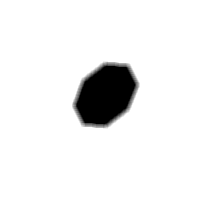

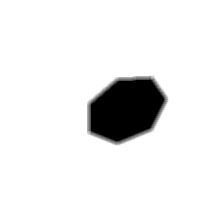

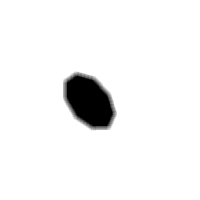

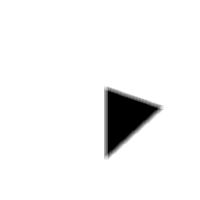

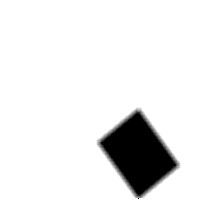

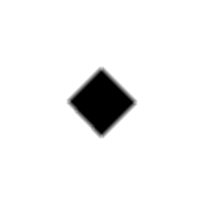

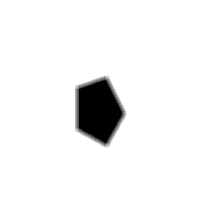

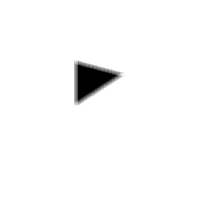

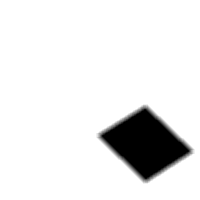

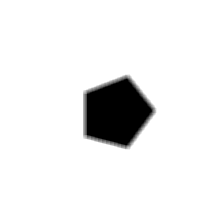

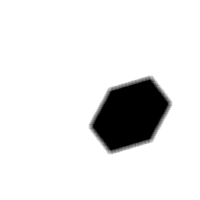

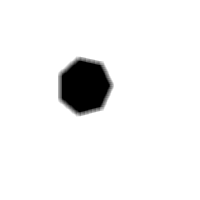

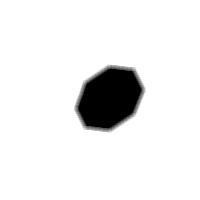

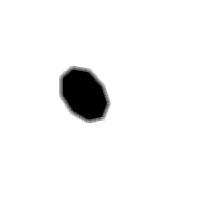

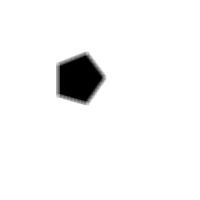

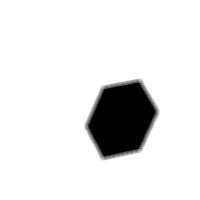

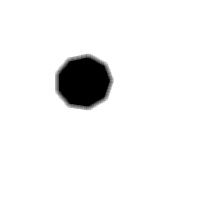

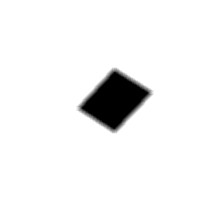

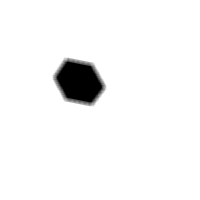

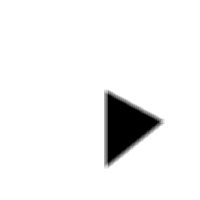

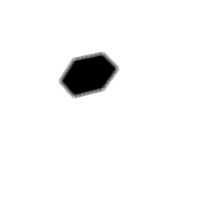

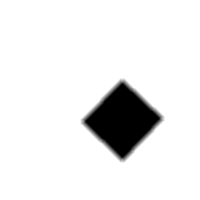

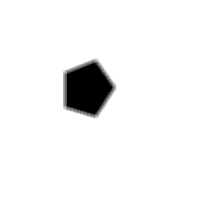

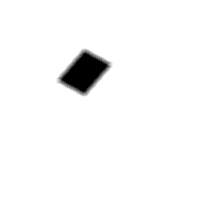

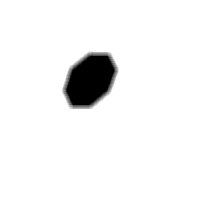

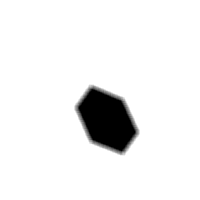

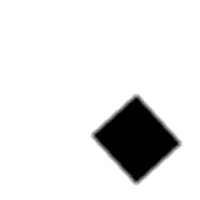

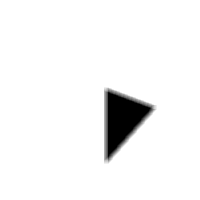

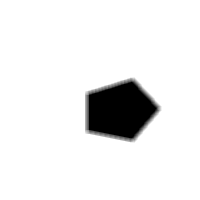

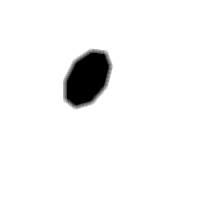

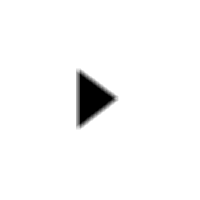

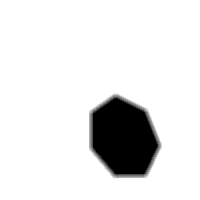

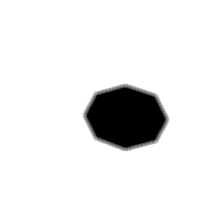

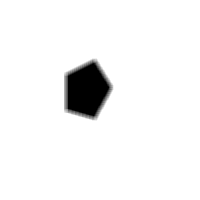

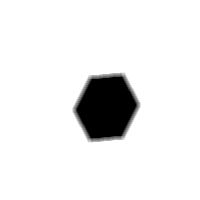

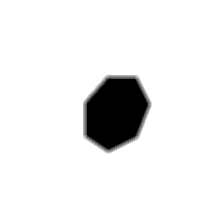

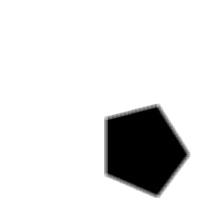

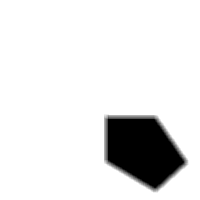

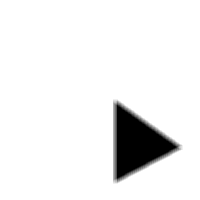

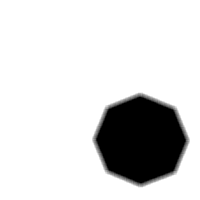

W0727 20:03:40.334778 22312 deprecation.py:506] From c:\users\jaures\documents\workspace\sujunn\env\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 16)        32784     
_________________________________________________________________
gaussian_noise (GaussianNois (None, 17, 17, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4624)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [4]:
train_size, test_size = 10000, 500# 10000, 500
train_set = gen_poly_data(train_size,side_range=(3,10), dim = (200,200), color=0, filled=True, output_dir = None, seed = 0)
test_set = gen_poly_data(test_size,side_range=(3,10), dim = (200,200), color=0, filled=True, output_dir = None, seed = 1)


model1,model2 = init_model(),init_model()
epochs1, epochs2 = 16,16

In [5]:
model1.compile(optimizer = tf.train.AdamOptimizer(), loss = 'mean_squared_error', metrics=['accuracy'])
model1.fit(np.array(train_set['x']), np.array(train_set['y']), batch_size = 32, epochs = epochs1, validation_split=0.1)



Train on 9000 samples, validate on 1000 samples
Epoch 1/16
9000/9000 [==============================] - 155s 17ms/sample - loss: 0.1183 - acc: 0.2207 - val_loss: 0.1048 - val_acc: 0.2750
Epoch 2/16
9000/9000 [==============================] - 177s 20ms/sample - loss: 0.0981 - acc: 0.3937 - val_loss: 0.0898 - val_acc: 0.4870
Epoch 3/16
9000/9000 [==============================] - 175s 19ms/sample - loss: 0.0863 - acc: 0.4864 - val_loss: 0.0800 - val_acc: 0.5410
Epoch 4/16
9000/9000 [==============================] - 175s 19ms/sample - loss: 0.0762 - acc: 0.5401 - val_loss: 0.0727 - val_acc: 0.5480
Epoch 5/16
9000/9000 [==============================] - 174s 19ms/sample - loss: 0.0690 - acc: 0.5967 - val_loss: 0.0628 - val_acc: 0.6720
Epoch 6/16
9000/9000 [==============================] - 179s 20ms/sample - loss: 0.0586 - acc: 0.6943 - val_loss: 0.0479 - val_acc: 0.7440
Epoch 7/16
9000/9000 [==============================] - 172s 19ms/sample - loss: 0.0479 - acc: 0.7591 - val_loss: 0.03

In [6]:
model2.compile(optimizer = tf.train.AdamOptimizer(), loss = 'categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
model2.fit(np.array(train_set['x']), np.array(train_set['y']), batch_size = 32, epochs = epochs2, validation_split=0.1)



Train on 9000 samples, validate on 1000 samples
Epoch 1/16
9000/9000 [==============================] - 175s 19ms/sample - loss: 1.8881 - acc: 0.2198 - categorical_accuracy: 0.2198 - val_loss: 1.6023 - val_acc: 0.3380 - val_categorical_accuracy: 0.3380
Epoch 2/16
9000/9000 [==============================] - 177s 20ms/sample - loss: 1.4802 - acc: 0.3977 - categorical_accuracy: 0.3977 - val_loss: 1.3175 - val_acc: 0.4890 - val_categorical_accuracy: 0.4890
Epoch 3/16
9000/9000 [==============================] - 155s 17ms/sample - loss: 1.2755 - acc: 0.4791 - categorical_accuracy: 0.4791 - val_loss: 1.1459 - val_acc: 0.5410 - val_categorical_accuracy: 0.5410
Epoch 4/16
9000/9000 [==============================] - 159s 18ms/sample - loss: 1.1431 - acc: 0.5240 - categorical_accuracy: 0.5240 - val_loss: 1.0568 - val_acc: 0.5510 - val_categorical_accuracy: 0.5510
Epoch 5/16
9000/9000 [==============================] - 168s 19ms/sample - loss: 1.0482 - acc: 0.5630 - categorical_accuracy: 0.5630

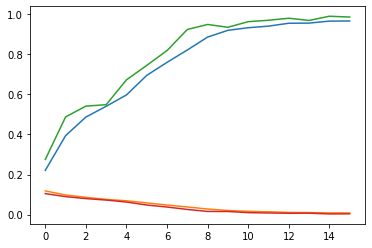

In [7]:
plt.plot(Out[5].history['acc'])
plt.plot(Out[5].history['loss'])
plt.plot(Out[5].history['val_acc'])
plt.plot(Out[5].history['val_loss'])
plt.show()

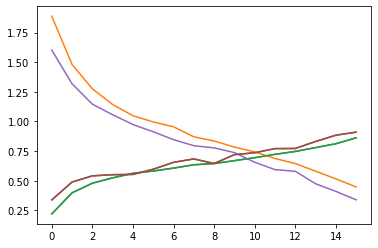

In [8]:
plt.plot(Out[6].history['acc'])
plt.plot(Out[6].history['loss'])
plt.plot(Out[6].history['categorical_accuracy'])
plt.plot(Out[6].history['val_acc'])
plt.plot(Out[6].history['val_loss'])
plt.plot(Out[6].history['val_categorical_accuracy'])
plt.show()

In [9]:
for i in range(test_size):
    print(model2.predict(np.array(test_set['x'][i]).reshape(1,200,200,1)),test_set['y'][i], sep='\n',end='\n======\n\n')

[[0.00051301 0.03513233 0.0223253  0.4245702  0.44677114 0.03556043
  0.03512753]]
[0. 0. 0. 1. 0. 0. 0.]

[[2.2950293e-03 9.6892506e-01 2.5374591e-04 2.5197016e-02 1.2173626e-03
  1.1342961e-03 9.7752456e-04]]
[0. 1. 0. 0. 0. 0. 0.]

[[1.3281214e-04 7.9679582e-04 9.4808376e-01 2.0194540e-03 4.2144962e-02
  5.0556604e-03 1.7666295e-03]]
[0. 0. 1. 0. 0. 0. 0.]

[[1.00593606e-03 9.84721959e-01 1.19488295e-02 1.70448053e-04
  1.93430332e-03 1.21827783e-04 9.67533997e-05]]
[0. 1. 0. 0. 0. 0. 0.]

[[4.8968097e-05 4.0168487e-04 4.8821359e-03 1.6253538e-02 3.3202586e-01
  3.5687044e-01 2.8951740e-01]]
[0. 0. 0. 0. 0. 1. 0.]

[[5.0063856e-04 7.3293294e-03 1.6504192e-03 8.9815819e-01 7.5847930e-03
  5.4333843e-02 3.0442741e-02]]
[0. 0. 0. 1. 0. 0. 0.]

[[3.6853380e-03 9.6258479e-01 3.2476857e-04 3.0176340e-02 9.0275804e-04
  1.3425456e-03 9.8350062e-04]]
[0. 1. 0. 0. 0. 0. 0.]

[[9.9781823e-01 1.7051961e-03 1.0719762e-05 4.2213566e-04 7.8973781e-06
  1.9236775e-05 1.6711607e-05]]
[1. 0. 0. 0. 0

Checking Guess #0:
	[\] - Match!
Checking Guess #1:
	[\] - Match!
Checking Guess #2:
	[\] - Match!
Checking Guess #3:
	[\] - Match!
Checking Guess #4:
	[\] - Match!
Checking Guess #5:
	[\] - Match!
Checking Guess #6:
	[\] - Match!
Checking Guess #7:
	[\] - Match!
Checking Guess #8:
	[\] - Match!
Checking Guess #9:
	[\] - Match!
Checking Guess #10:
	[\] - Match!
Checking Guess #11:
	[\] - Match!
Checking Guess #12:
	[\] - Match!
Checking Guess #13:
	[\] - Match!
Checking Guess #14:
	[\] - Match!
Checking Guess #15:
	[\] - Match!
Checking Guess #16:
	[\] - Match!
Checking Guess #17:
	[\] - Match!
Checking Guess #18:
	[\] - Match!
Checking Guess #19:
	[\] - Match!
Checking Guess #20:
	[\] - Match!
Checking Guess #21:
	[\] - Match!
Checking Guess #22:
	[\] - Match!
Checking Guess #23:
	[\] - Match!
Checking Guess #24:
	[\] - Match!
Checking Guess #25:
	[\] - Match!
Checking Guess #26:
	[\] - Match!
Checking Guess #27:
	[\] - Match!
Checking Guess #28:
	[\] - Match!
Checking Guess #29:
	[\]

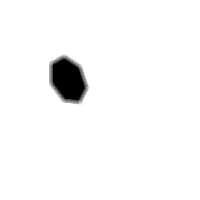

[0. 0. 0. 0. 1. 0. 0.] 

Checking Guess #65:
	[\] - Match!
Checking Guess #66:
	[\] - Match!
Checking Guess #67:
	[\] - Match!
Checking Guess #68:
	[\] - Match!
Checking Guess #69:
	[\] - Match!
Checking Guess #70:
	[\] - Match!
Checking Guess #71:
	[\] - Match!
Checking Guess #72:
	[\] - Match!
Checking Guess #73:
	[\] - Match!
Checking Guess #74:
	[\] - Match!
Checking Guess #75:
	[\] - Match!
Checking Guess #76:
	[\] - Match!
Checking Guess #77:
	[\] - Match!
Checking Guess #78:
	[\] - Match!
Checking Guess #79:
	[\] - Match!
Checking Guess #80:
	[\] - Match!
Checking Guess #81:
	[\] - Match!
Checking Guess #82:
	[\] - Match!
Checking Guess #83:
	[\] - Match!
Checking Guess #84:
	[\] - Match!
Checking Guess #85:
	[\] - Match!
Checking Guess #86:
	[\] - Match!
Checking Guess #87:
	[\] - Match!
Checking Guess #88:
	[\] - Match!
Checking Guess #89:
	[\] - Match!
Checking Guess #90:
	[\] - Match!
Checking Guess #91:
	[\] - Match!
Checking Guess #92:
	[\] - Match!
Checking Guess #93:
	[\

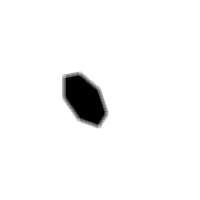

[0. 0. 0. 0. 1. 0. 0.] 

Checking Guess #144:
	[\] - Match!
Checking Guess #145:
	[\] - Match!
Checking Guess #146:
	[\] - Match!
Checking Guess #147:
	[\] - Match!
Checking Guess #148:
	[\] - Match!
Checking Guess #149:
	[\] - Match!
Checking Guess #150:
	[\] - Match!
Checking Guess #151:
	[\] - Match!
Checking Guess #152:
	[\] - Match!
Checking Guess #153:
	[\] - Match!
Checking Guess #154:
	[\] - Match!
Checking Guess #155:
	[\] - Match!
Checking Guess #156:
	[\] - Match!
Checking Guess #157:
	[\] - Match!
Checking Guess #158:
	[\] - Match!
Checking Guess #159:
	[\] - Match!
Checking Guess #160:
	[\] - Match!
Checking Guess #161:
	[\] - Match!
Checking Guess #162:
	[\] - Match!
Checking Guess #163:
	[\] - Match!
Checking Guess #164:
	[\] - Match!
Checking Guess #165:
	[\] - Match!
Checking Guess #166:
	[\] - Match!
Checking Guess #167:
	[\] - Match!
Checking Guess #168:
	[\] - Match!
Checking Guess #169:
	[\] - Match!
Checking Guess #170:
	[\] - Match!
Checking Guess #171:
	[\] - Ma

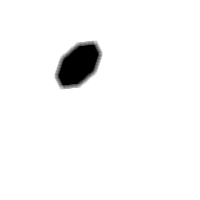

[0. 0. 0. 0. 0. 1. 0.] 

Checking Guess #310:
	[\] - Match!
Checking Guess #311:
	[\] - Match!
Checking Guess #312:
	[\] - Match!
Checking Guess #313:
	[\] - Match!
Checking Guess #314:
	[\] - Match!
Checking Guess #315:
	[\] - Match!
Checking Guess #316:
	[\] - Match!
Checking Guess #317:
	[\] - Match!
Checking Guess #318:
	[\] - Match!
Checking Guess #319:
	[\] - Match!
Checking Guess #320:
	[\] - Match!
Checking Guess #321:
	[\] - Match!
Checking Guess #322:
	[\] - Match!
Checking Guess #323:
	[\] - Match!
Checking Guess #324:
	[\] - Match!
Checking Guess #325:
	[\] - Match!
Checking Guess #326:
	[\] - Match!
Checking Guess #327:
	[\] - Match!
Checking Guess #328:
	[\] - Match!
Checking Guess #329:
	[\] - Match!
Checking Guess #330:
	[\] - Match!
Checking Guess #331:
	[\] - Match!
Checking Guess #332:
	[\] - Match!
Checking Guess #333:
	[\] - Match!
Checking Guess #334:
	[\] - Match!
Checking Guess #335:
	[\] - Match!
Checking Guess #336:
	[\] - Match!
Checking Guess #337:
	[\] - Ma

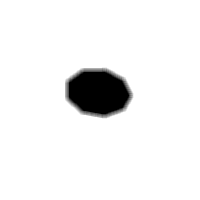

[0. 0. 0. 0. 0. 0. 1.] 

Checking Guess #346:
	[\] - Match!
Checking Guess #347:
	[\] - Match!
Checking Guess #348:
	[\] - Match!
Checking Guess #349:
	[\] - Match!
Checking Guess #350:
	[\] - Match!
Checking Guess #351:
	[\] - Match!
Checking Guess #352:
	[\] - Match!
Checking Guess #353:
	[\] - Match!
Checking Guess #354:
	[\] - Match!
Checking Guess #355:
	[\] - Match!
Checking Guess #356:
	[\] - Match!
Checking Guess #357:
	[\] - Match!
Checking Guess #358:
	[\] - Match!
Checking Guess #359:
	[\] - Match!
Checking Guess #360:
	[\] - Match!
Checking Guess #361:
	[\] - Match!
Checking Guess #362:
	[\] - Match!
Checking Guess #363:
	[\] - Match!
Checking Guess #364:
	[\] - Match!
Checking Guess #365:
	[\] - Match!
Checking Guess #366:
	[\] - Match!
Checking Guess #367:
	[\] - Match!
Checking Guess #368:
	[\] - Match!
Checking Guess #369:
	[\] - Match!
Checking Guess #370:
	[\] - Match!
Checking Guess #371:
	[\] - Match!
Checking Guess #372:
	[\] - Match!
Checking Guess #373:
	[\] - Ma

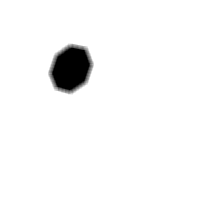

[0. 0. 0. 0. 0. 1. 0.] 

Checking Guess #375:
	[\] - Match!
Checking Guess #376:
	[\] - Match!
Checking Guess #377:
	[\] - Match!
Checking Guess #378:
	[\] - Match!
Checking Guess #379:
	[\] - Match!
Checking Guess #380:
	[\] - Match!
Checking Guess #381:
	[\] - Match!
Checking Guess #382:
	[\] - Match!
Checking Guess #383:
	[\] - Match!
Checking Guess #384:
	[\] - Match!
Checking Guess #385:
	[\] - Match!
Checking Guess #386:
	[\] - Match!
Checking Guess #387:
	[\] - Match!
Checking Guess #388:
	[\] - Match!
Checking Guess #389:
	[\] - Match!
Checking Guess #390:
	[\] - Match!
Checking Guess #391:
	[\] - Match!
Checking Guess #392:
	[\] - Match!
Checking Guess #393:
	[\] - Match!
Checking Guess #394:
	[\] - Match!
Checking Guess #395:
	[\] - Match!
Checking Guess #396:
	[\] - Match!
Checking Guess #397:
	[\] - Match!
Checking Guess #398:
	[\] - Match!
Checking Guess #399:
	[\] - Match!
Checking Guess #400:
	[\] - Match!
Checking Guess #401:
	[\] - Match!
Checking Guess #402:
	[\] - Ma

In [10]:
correct = 0
for i in range(test_size):
    print('Checking Guess #{}:'.format(i),end='\n\t')
    p = model1.predict(test_set['x'][i].reshape(1,200,200,1))
    if np.argmax(p) == np.argmax(test_set['y'][i]):
        print('[\] - Match!')
        correct = correct + 1
    else:
        
        print('[X] - Miss')        
        
        display(test_set['img'][i])
        print(test_set['y'][i],'\n')

print('Results: {}%'.format(correct/test_size * 100))

In [11]:
correct = 0
for i in range(test_size):
    print('Checking Guess #{}:'.format(i),end='\n\t')
    if np.argmax(model2.predict(np.array(test_set['x'][i]).reshape(1,200,200,1))) == np.argmax(test_set['y'][i]):
        print('[\] - Match!')
        correct = correct + 1
    else:
        print('[X] - Miss')

print('Results: {}%'.format(correct/test_size * 100))

Checking Guess #0:
	[X] - Miss
Checking Guess #1:
	[\] - Match!
Checking Guess #2:
	[\] - Match!
Checking Guess #3:
	[\] - Match!
Checking Guess #4:
	[\] - Match!
Checking Guess #5:
	[\] - Match!
Checking Guess #6:
	[\] - Match!
Checking Guess #7:
	[\] - Match!
Checking Guess #8:
	[\] - Match!
Checking Guess #9:
	[X] - Miss
Checking Guess #10:
	[\] - Match!
Checking Guess #11:
	[X] - Miss
Checking Guess #12:
	[\] - Match!
Checking Guess #13:
	[\] - Match!
Checking Guess #14:
	[\] - Match!
Checking Guess #15:
	[\] - Match!
Checking Guess #16:
	[\] - Match!
Checking Guess #17:
	[\] - Match!
Checking Guess #18:
	[\] - Match!
Checking Guess #19:
	[\] - Match!
Checking Guess #20:
	[\] - Match!
Checking Guess #21:
	[\] - Match!
Checking Guess #22:
	[\] - Match!
Checking Guess #23:
	[X] - Miss
Checking Guess #24:
	[\] - Match!
Checking Guess #25:
	[X] - Miss
Checking Guess #26:
	[\] - Match!
Checking Guess #27:
	[X] - Miss
Checking Guess #28:
	[\] - Match!
Checking Guess #29:
	[\] - Match!
Ch